# Feature engineering

In [ ]:
import numpy as np
import pandas as pd
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline 
from math import log, exp, sqrt   # import some useful mathematical stuff 
from sklearn import preprocessing


from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel 

In [ ]:
#set the path 
%cd /content/drive/My Drive/Self Case Study 1/data/output/FD001

/content/drive/My Drive/Self Case Study 1/data/output/FD001


In [ ]:
Train = pd.read_csv('Predictive_Training_F0001.csv') 
Test = pd.read_csv('Predictive_Testing_F0001.csv') 

In [ ]:
Train.shape

(20631, 27)


**calculate pressure,temperature and density of an aircraft at its flying altitudes.**

As the density of the air increases (lower density altitude), airplane performance increases and conversely, as air density decreases (higher density altitude), airplane performance decreases. A decrease in air density means a high density altitude; an increase in air density means a lower density altitude. [REF](https://nptel.ac.in/content/storage2/courses/101106041/Chapter%202%20-Lecture%205%2020-12-2011.pdf)


In [ ]:
# return pressure, temperature depending on provided altitude. Units are SI (m, PA, Kelvin) 
def isa(altitude):
  # troposphere
  if altitude<=11000:
    if altitude == 0:
      temperature =    228.15
      pressure    =    1.01325
      density    =     1.225 
    else:
      temperature = 288.15 - 0.0065 * altitude
      pressure =   1.01325 * (temperature/288.15)**5.25588
      density  =   (pressure/(287.05287*temperature))*10**5
  # stratosphere
  elif altitude <=20000:
    temperature =        288.15 - 0.0065 *11000
    pressure_11000    =  1.01325 * (temperature/288.15)**5.25588 
    density_11000     =  (pressure_11000/(287.05287*temperature))*10**5
    ratio             =  exp((-9.80665*(altitude-11000))/(287.05287*temperature))
    pressure          =  pressure_11000*ratio
    density           =  density_11000*ratio         
  else:
    raise ValueError('altitude out of range [0-20000m]')
  return  pressure,temperature,density

In [ ]:
Train[['Atm_pressure','Atm_temp','Atm_density']] = Train.apply(lambda row: isa(row['Altitude']),axis=1,result_type="expand") 
Test[['Atm_pressure','Atm_temp','Atm_density']] = Test.apply(lambda row: isa(row['Altitude']),axis=1,result_type="expand")  

**Aircraft flying velocity (Va)**

The Mach number (M) is simply the ratio of the vehicle's velocity (V) divided by the speed of sound at that altitude. 

Mach number = $\frac{V_a}{\sqrt{\gamma RT}}$ where T is atmospheric temperature.

In [ ]:
def aircraft_velocity(Mach_number,Atm_temp):
  gamma_air = 1.4  #  specific heats of air
  R= 287 # Gas constant
  V_a= Mach_number*(sqrt(gamma_air*R*Atm_temp))
  return V_a 

In [ ]:
Train['Va'] = Train.apply(lambda row:aircraft_velocity(row['Mach_number'],row['Atm_temp']),axis=1) 
Test['Va'] =  Test.apply(lambda row:aircraft_velocity(row['Mach_number'],row['Atm_temp']),axis=1)

**High pressure turbine outlet temperature(T48):**

The amount work done by the LPT(low pressure turbin) should be equal to the fan and low pressure compresser(LPC).

$BPR = \frac {m_c} {m_H} $

$m_H(1+f)*C_p{gas}(T48-T50)*\eta_t  = m_c*C_P{air}*(T24-T2)$

In [ ]:
def HPT_outlet(T24,T2,T50,BPR):
  cp_gas = 1147
  cp_air = 1005
  transmission_efficiency = 0.985
  T48= T50+(cp_air*(T24-T2)*(BPR+1))/(cp_gas*transmission_efficiency) 
  return T48 

In [ ]:
Train['T48'] = Train.apply(lambda row :HPT_outlet(row['T24'],row['T2'],row['T50'],row['BPR']),axis= 1) 
Test['T48'] = Test.apply(lambda row :HPT_outlet(row['T24'],row['T2'],row['T50'],row['BPR']),axis= 1) 

**Turbine entry temperature(T41)**

Since engine life is greatly reduced at high turbine inlet temperatures, the operator should not exceed the exhaust temperatures specified for continuous operation.High Turbine entry temperature can be an indication of degraded engine performance.

work done by the HPT should be equal to the High compressor work.

$m_H(1+f)*C_p{gas}(T41-T48)*\eta_t  = m_H*C_P{air}*(T30-T24) $


In [ ]:
def turbin_inlet(T48,T30,T24):
  cp_gas = 1147
  cp_air = 1005
  transmission_efficiency = 0.985
  T41 = T48+(cp_air*(T30-T24))/(cp_gas*transmission_efficiency) 
  return T41 

In [ ]:
Train['T41'] = Train.apply(lambda row: turbin_inlet(row['T48'],row['T30'],row['T24']),axis = 1) 
Test['T41'] = Test.apply(lambda row: turbin_inlet(row['T48'],row['T30'],  row['T24']),axis = 1)  

In [ ]:
Train['turbine_expansion_ratio'] = (Train.T41-Train.T50)/Train.T41 
Test['turbine_expansion_ratio'] = (Test.T41-Test.T50)/Test.T41 

**High pressure compressor(HPC):**

the temperature and pressure ratios are then related via the isentropic formula.[REF](https://nptel.ac.in/content/storage2/courses/101101002/downloads/Lect-08.pdf)

$\displaystyle \eta_t = \frac {(P30_s/P24)^{\frac {\gamma-1}\gamma}-1} {(T30/T24)-1} $


In [ ]:
def HPC_ratio(T30,T24):
  gamma_air = 1.4
  Compressor_efficiency= 0.85
  ratio = (Compressor_efficiency*((T30/T24)-1) +1)**(gamma_air/(gamma_air-1)) 
  return ratio 

In [ ]:
Train['HPC_ratio'] = Train.apply(lambda row: HPC_ratio(row['T30'],row['T24']),axis=1) 
Test['HPC_ratio'] = Test.apply(lambda row: HPC_ratio(row['T30'],row['T24']),axis=1) 

**Fan Exit Temperature(T21)**

The power balance between the turbine and compressor now includes the fan, that
is, we have to write

$ \eta_m*m_{hot}*(1+f)*C_{p_{hotgas}}*(T48-T50) =  m_{hot}*C_{p_{air}}*(T24-T2)+BPR*m_{hot}*C_{p_{air}}*(T21-T2)$



In [ ]:
def fan_exit_temperature(T2,T24,T48,T50,fuel_air_ratio,BPR):
  cp_air =1005
  cp_gas = 1147
  transmission_efficiency = 0.985

  T21 = T2+ (((1+fuel_air_ratio)*(T48-T50)*(cp_gas/cp_air)*transmission_efficiency - (T24-T2))/BPR)
  return T21

In [ ]:
Train['T21'] = Train.apply(lambda row: fan_exit_temperature(row['T2'],row['T24'],row['T48'],row['T50'],row['fuel_air_ratio'],row['BPR']),axis=1) 
Test['T21']  = Test.apply(lambda row: fan_exit_temperature(row['T2'], row['T24'],row['T48'],row['T50'],row['fuel_air_ratio'],row['BPR']),axis=1)  

**Fan pressure ratio**

Fan pressure and temperature ratio through adiabatic fan efficiency

$\displaystyle \eta_t = \frac {(P21_s/P2)^{\frac {\gamma-1}\gamma}-1} {(T21/T2)-1} $

In [ ]:
def Fan_pressure_ratio(Atm_pressure,P2, T21,T2):
  fan_efficiency =0.99
  gamma_air = 1.4
  nozzle_efficiency = 0.995
  R = 287
  cp_air = 1005

  ratio= (1+fan_efficiency*((T21/T2)-1))**(gamma_air/(gamma_air-1))
  
  P21 = ratio*P2

  choked_ration =  (1- (gamma_air-1)/((gamma_air+1)*nozzle_efficiency))**(-gamma_air/(gamma_air-1)) # choked_ration = P21/at choked_pressure  

  choked_pressure = P21/choked_ration 

  # =============================
# Nozzle is not chocked 

  if Atm_pressure	 >= choked_pressure:

    isp_ratio = (Atm_pressure	/P21)**((gamma_air-1)/gamma_air) # we need to consider atm_pressure

    exit_temp_nozzle = (1- (1- isp_ratio)*nozzle_efficiency)*T21 # Exhaust Gas Temperature  # nozzle_efficiency = (bypass nozzle exit temperature -Nozzle exit temperature) / (fan exit temperature-ideal Nozzle exit temperature)
    
    exit_velocity = sqrt(2*cp_air*(T21-exit_temp_nozzle)) 

#==============================
# Nozzle is chocked case 
  else:
    isp_ratio = (choked_pressure/P21)**((gamma_air-1)/gamma_air) # nozzle_efficiency = (bypass nozzle exit temperature -Nozzle exit temperature) / (fan exit temperature-ideal Nozzle exit temperature)
    
    exit_temp_nozzle = (1- (1- isp_ratio)*nozzle_efficiency)*T21  # nozzle_efficiency = (turbine exit temperature -Nozzle exit temperature) / (turbine exit temperature-ideal Nozzle exit temperature)
    
    exit_velocity = sqrt(gamma_air*R*exit_temp_nozzle) 

  return ratio,P21,exit_temp_nozzle, exit_velocity 

In [ ]:
Train[['Fan_pressure_ratio','P21','T13','V_bypass']] =  Train.apply(lambda row:  Fan_pressure_ratio(row['Atm_pressure'],row['P2'],row['T21'],row['T2']),axis=1,result_type="expand")
Test[['Fan_pressure_ratio','P21','T13','V_bypass']] =   Test.apply(lambda row:   Fan_pressure_ratio(row['Atm_pressure'],row['P2'],row['T21'],row['T2']),axis=1,result_type="expand")  

**Low pressure compressor ratio:**

compressor pressure and temperature ratio through adiabatic compressor efficiency

$\displaystyle \eta_t = \frac {(P24_s/P21)^{\frac {\gamma-1}\gamma}-1} {(T24/T21)-1} $


In [ ]:
def Low_pressure_compressor_ratio(T24,T21):
  gamma_air = 1.4
  Compressor_efficiency= 0.85 
  ratio = (Compressor_efficiency*((T24/T21)-1) +1)**(gamma_air/(gamma_air-1)) 
  return ratio

In [ ]:
Train['LPC_ratio'] = Train.apply(lambda row: Low_pressure_compressor_ratio(row['T24'],row['T21']),axis=1) 
Test['LPC_ratio'] = Test.apply(lambda row:   Low_pressure_compressor_ratio(row['T24'],row['T21']),axis=1) 

In [ ]:
Train['P50'] = Train['epr']*Train['P2']  # epr = Engine pressure ratio (P50/P2), P50 = epr*P2 
Test['P50'] = Test['epr']*Test['P2']  # epr = Engine pressure ratio (P50/P2), P50 = epr*P2 

In [ ]:
# Exhaust Gas Temperature
def EGT(P50,T50,atm_pressure):
  nozzle_efficiency =0.95  # efficiency of nozzle (assumed)
  gamma_gas = 1.33
  cp_gas = 1147 

  R = ((gamma_gas-1)*cp_gas)/gamma_gas 

  nozzle_pressure_ratio = P50/atm_pressure  # Total temperature at LPT outlet/atmospheric pressure 

  # check nozzle choked condition or not 

  choked_ration =  (1- (gamma_gas-1)/((gamma_gas+1)*nozzle_efficiency))**(-gamma_gas/(gamma_gas-1)) # choked_ration = P50/at choked_pressure 
  choked_pressure = P50/choked_ration
  
# =============================
# Nozzle is not chocked 

  if atm_pressure >= choked_pressure:

    isp_ratio = (atm_pressure/P50)**((gamma_gas-1)/gamma_gas) # we need to consider atm_pressure

    T90 = (1- (1- isp_ratio)*nozzle_efficiency)*T50 # Exhaust Gas Temperature  # nozzle_efficiency = (turbine exit temperature -Nozzle exit temperature) / (turbine exit temperature-ideal Nozzle exit temperature)
    
    exit_velocity = sqrt(2*cp_gas*(T50-T90)) 

#==============================
# Nozzle is chocked case 
  else:
    isp_ratio = (choked_pressure/P50)**((gamma_gas-1)/gamma_gas) # nozzle_efficiency = (turbine exit temperature -Nozzle exit temperature) / (turbine exit temperature-ideal Nozzle exit temperature)
    
    T90 = (1- (1- isp_ratio)*nozzle_efficiency)*T50  # nozzle_efficiency = (turbine exit temperature -Nozzle exit temperature) / (turbine exit temperature-ideal Nozzle exit temperature)
    
    exit_velocity = sqrt(gamma_gas*R*T90) 

  return T90, exit_velocity 

In [ ]:
Train[['T90','Ve']]=  Train.apply(lambda row: EGT(row['P50'],row['T50'],row['Atm_pressure']),axis = 1,result_type="expand")
Test[['T90','Ve']] =  Test.apply(lambda row: EGT(row['P50'],row['T50'],row['Atm_pressure']),axis = 1,result_type="expand")

In [ ]:
Train['EGT_margin']= Train['T90'].apply(lambda x: 1223.15-x) 
Test['EGT_margin']= Test['T90'].apply(lambda x: 1223.15-x) 

In [ ]:
Train['Nc/Nf'] = Train['Nc']/Train['Nf'] 
Test['Nc/Nf'] = Test['Nc']/Test['Nf'] 

In [ ]:
Train['PCNfRdmd '] = (Train.NRf - Train.Nf)/Train.Nf
Train['PCNcRdmd '] = (Train.Nc-Train.NRf)/Train.Nc 

Test['PCNfRdmd '] = (Test.NRf - Test.Nf)/Test.Nf
Test['PCNcRdmd '] = (Test.Nc-Test.NRf)/Test.Nc 

**Turbine pressure ration (TPR):** which is the ratio of the air pressure exiting the turbine to the air pressure entering the turbine. 

Isentropic efficiency of the turbine = Actual turbine work for a differential pressure change / Ideal turbine work for a differential pressure change 

$\displaystyle \eta_t = \frac {1- (T48/T41)} {1-(P48_s/P41)^{\frac {\gamma-1}\gamma}}$





In [ ]:
def HPT_TPR(T41,T48):
  gamma_gas = 1.33
  Turbine_efficiency= 0.90
  pressur_ratio= (1- ((T41-T48)/(Turbine_efficiency*T41)))**(gamma_gas/(gamma_gas-1))
  return pressur_ratio 

In [ ]:
Train['HPT_TPR'] =  Train.apply(lambda row: HPT_TPR(row['T41'],row['T48']),axis = 1) 
Test['HPT_TPR'] =   Test.apply(lambda row: HPT_TPR(row['T41'],row['T48']),axis = 1)

In [ ]:
Train['LPT_TPR'] =  Train.apply(lambda row: HPT_TPR(row['T48'],row['T50']),axis = 1)
Test['LPT_TPR'] =   Test.apply(lambda row: HPT_TPR(row['T48'],row['T50']),axis = 1)

In [ ]:
Train['TPR'] =  Train.apply(lambda row: HPT_TPR(row['T41'],row['T50']),axis = 1) 
Test['TPR'] =   Test.apply(lambda row: HPT_TPR(row['T41'],row['T50']),axis = 1)

**Mass of fuel flow, Mass of hot air and Mass of cold air:**

 From given data phi is given Phi = mass flow of fuel/Static pressure at HPC outlet ,  

 from that mass flow of fuel = phi* Static pressure at HPC outlet

 From given data point fuel-air ratio = mass flow of fuel/mass flow of hot air

 From given data point Bypass Ratio = Mass flow of clod air/Mass flow of hot air


In [ ]:
def Mass_flow (phi,Ps30,fuel_air_ratio,BPR): 
  Mass_flow_fuel = phi*Ps30*0.0001259978805556
  Mass_flow_hotair = Mass_flow_fuel/fuel_air_ratio 
  Mass_flow_coldair = BPR*Mass_flow_hotair 
  return Mass_flow_fuel,Mass_flow_hotair,Mass_flow_coldair 

In [ ]:
Train[['M_fuel','M_Hot','M_cold']] = Train.apply(lambda row: Mass_flow(row['phi'],row['Ps30'],row['fuel_air_ratio'],row['BPR']),axis=1,result_type="expand") 
Test[['M_fuel','M_Hot','M_cold']]  = Test.apply(lambda row: Mass_flow(row['phi'],row['Ps30'],row['fuel_air_ratio'],row['BPR']),axis=1,result_type="expand") 

**Corrected mass flow**

Corrected Flow is the mass flow that would pass through a device (e.g. compressor, bypass duct, etc.) if the inlet pressure and temperature corresponded to ambient conditions at Sea Level.

$Corrected flow = \frac {Real Mass Flow *\sqrt{T/T_{ref}}}{P/P_{ref}}$

In [ ]:
def Corrected_flow(M_cold,M_Hot,T2,P2,T21,P21):
  atm_temperature =    228.15
  atm_pressure    =    1.01325 
  w_f = (M_cold*sqrt(T2/atm_temperature))/(P2/atm_pressure) #fan_corrected_mass_flow 
  w_c = (M_Hot*sqrt(T21/atm_temperature))/(P21/atm_pressure) #fan_corrected_mass_flow 

  return w_f,w_c

In [ ]:
Train[['W_f','W_c']] = Train.apply(lambda row: Corrected_flow(row['M_cold'],row['M_Hot'],row['T2'],row['P2'],row['T21'],row['P21']),axis=1,result_type="expand")
Test[['W_f','W_c']] = Test.apply(lambda row: Corrected_flow(row['M_cold'],row['M_Hot'],row['T2'],row['P2'],row['T21'],row['P21']),axis=1,result_type="expand") 

Performance deterioration increases the operating cost, due to the reduction in thrust output and higher fuel consumption, and also increases the engine maintenance cost.

**Thrust for a turbofan engine:**

$m_{hotair}*(1+f)*V_e + BPR*m_{hotair}*V_{bypass}- (1+BPR)*m_{hotair}*V_a$

In [ ]:
def thrust(fuel_air_ratio,BPR,M_Hot,V_bypass,Ve,Va):
  Fan_thrust = BPR*M_Hot*V_bypass - BPR*M_Hot*Va 

  core_thrust = M_Hot*(1+fuel_air_ratio)*Ve - M_Hot*Va 

  Thrust= M_Hot*(1+fuel_air_ratio)*Ve + BPR*M_Hot*V_bypass - (1+BPR)*M_Hot*Va 

  fan_contribution = Fan_thrust/Thrust # The fan contribution to the engine net thrust is F n−fan ∕F n−total 
  core_contribution = core_thrust/Thrust # The core contribution to the total net thrust is F n−core ∕F n−total

  TSFC = (fuel_air_ratio*M_Hot*10**6)/Thrust # TSFC may also be thought of as fuel consumption (grams/second) per unit of thrust (kilonewtons, or kN).

  return Thrust,Fan_thrust,core_thrust,fan_contribution,core_contribution,TSFC

In [ ]:
Train[['Thrust','Fan_thrust','core_thrust','fan_contribution','core_contribution','TSFC']] = Train.apply(lambda row: thrust(row['fuel_air_ratio'],row['BPR'],row['M_Hot'],row['V_bypass'],row['Ve'],row['Va']),axis = 1,result_type="expand") 
Test[['Thrust','Fan_thrust','core_thrust','fan_contribution','core_contribution','TSFC']] =  Test.apply(lambda row:  thrust(row['fuel_air_ratio'],row['BPR'],row['M_Hot'],row['V_bypass'],row['Ve'],row['Va']),axis = 1,result_type="expand")

**Thermal efficiency**

The ability of an engine to convert the thermal energy inherent in the fuel (which is unleashed in a chemical reaction) to a net kinetic energy gain of the working medium is called the engine thermal efficienc.

**propulsive efficiency**
The fraction of the net mechanical output of the engine which is converted into thrust power is called the propulsive efficiency. 

In [ ]:
def Thermal_efficiency(fuel_air_ratio,BPR,V_bypass,Ve,Va,Thrust,M_Hot,M_cold):

  Q_R = 42000*1000 # Heat of reaction of the fuel

  Thermal_efficiency = (((1+fuel_air_ratio)*(Ve)**2 + BPR*(V_bypass)**2 - (1+BPR)*(Va)**2)/(2*fuel_air_ratio*Q_R))*100

  propulsive_efficiency = (2*Thrust*Va*1000)/(M_Hot*(1+fuel_air_ratio)*(Ve)**2 + M_cold*BPR*(V_bypass)**2 - (M_cold+M_Hot)*(Va)**2)

  return Thermal_efficiency,propulsive_efficiency 

In [ ]:
Train[['Thermal_efficiency','propulsive_efficiency']]= Train.apply(lambda row: Thermal_efficiency(row['fuel_air_ratio'],row['BPR'],row['V_bypass'],row['Ve'],row['Va'],row['Thrust'],row['M_Hot'],row['M_cold']),axis = 1,result_type="expand") 
Test[['Thermal_efficiency','propulsive_efficiency']]= Test.apply(lambda row:  Thermal_efficiency(row['fuel_air_ratio'],row['BPR'],row['V_bypass'],row['Ve'],row['Va'],row['Thrust'],row['M_Hot'],row['M_cold']),axis = 1,result_type="expand") 

In [ ]:
Train.to_csv('Feature_Engg_Train_F0001.csv', encoding='utf-8',index = None)  
Test.to_csv('Feature_Engg_Test_F0001.csv', encoding='utf-8',index = None) 

In [ ]:
import statsmodels.api as sm 
target_col = "RUL"
X =Train.loc[:,Train.columns != target_col]
y = Train.loc[:, target_col]

In [ ]:
X_with_constant = sm.add_constant(X)
model = sm.OLS(y, X_with_constant) 

In [ ]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     975.4
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:38:28   Log-Likelihood:            -1.0481e+05
No. Observations:               20631   AIC:                         2.097e+05
Df Residuals:                   20585   BIC:                         2.101e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Engine_No                 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
def generate_vif(df, target):
    X_var = add_constant(df.loc[:, df.columns != target])
    return pd.Series([variance_inflation_factor(X_var.values, i) for i in range(X_var.shape[1])],index=X_var.columns,)

In [ ]:
generate_vif(Train,'RUL')

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Engine_No                1.028066e+00
Time_in_cycles           2.364234e+00
Altitude                 6.433714e+14
Mach_number              4.022144e+03
TRA                      0.000000e+00
                             ...     
fan_contribution         1.032603e+08
core_contribution        2.184745e+09
TSFC                     9.634532e+08
Thermal_efficiency       6.567915e+09
propulsive_efficiency    3.345058e+06
Length: 63, dtype: float64

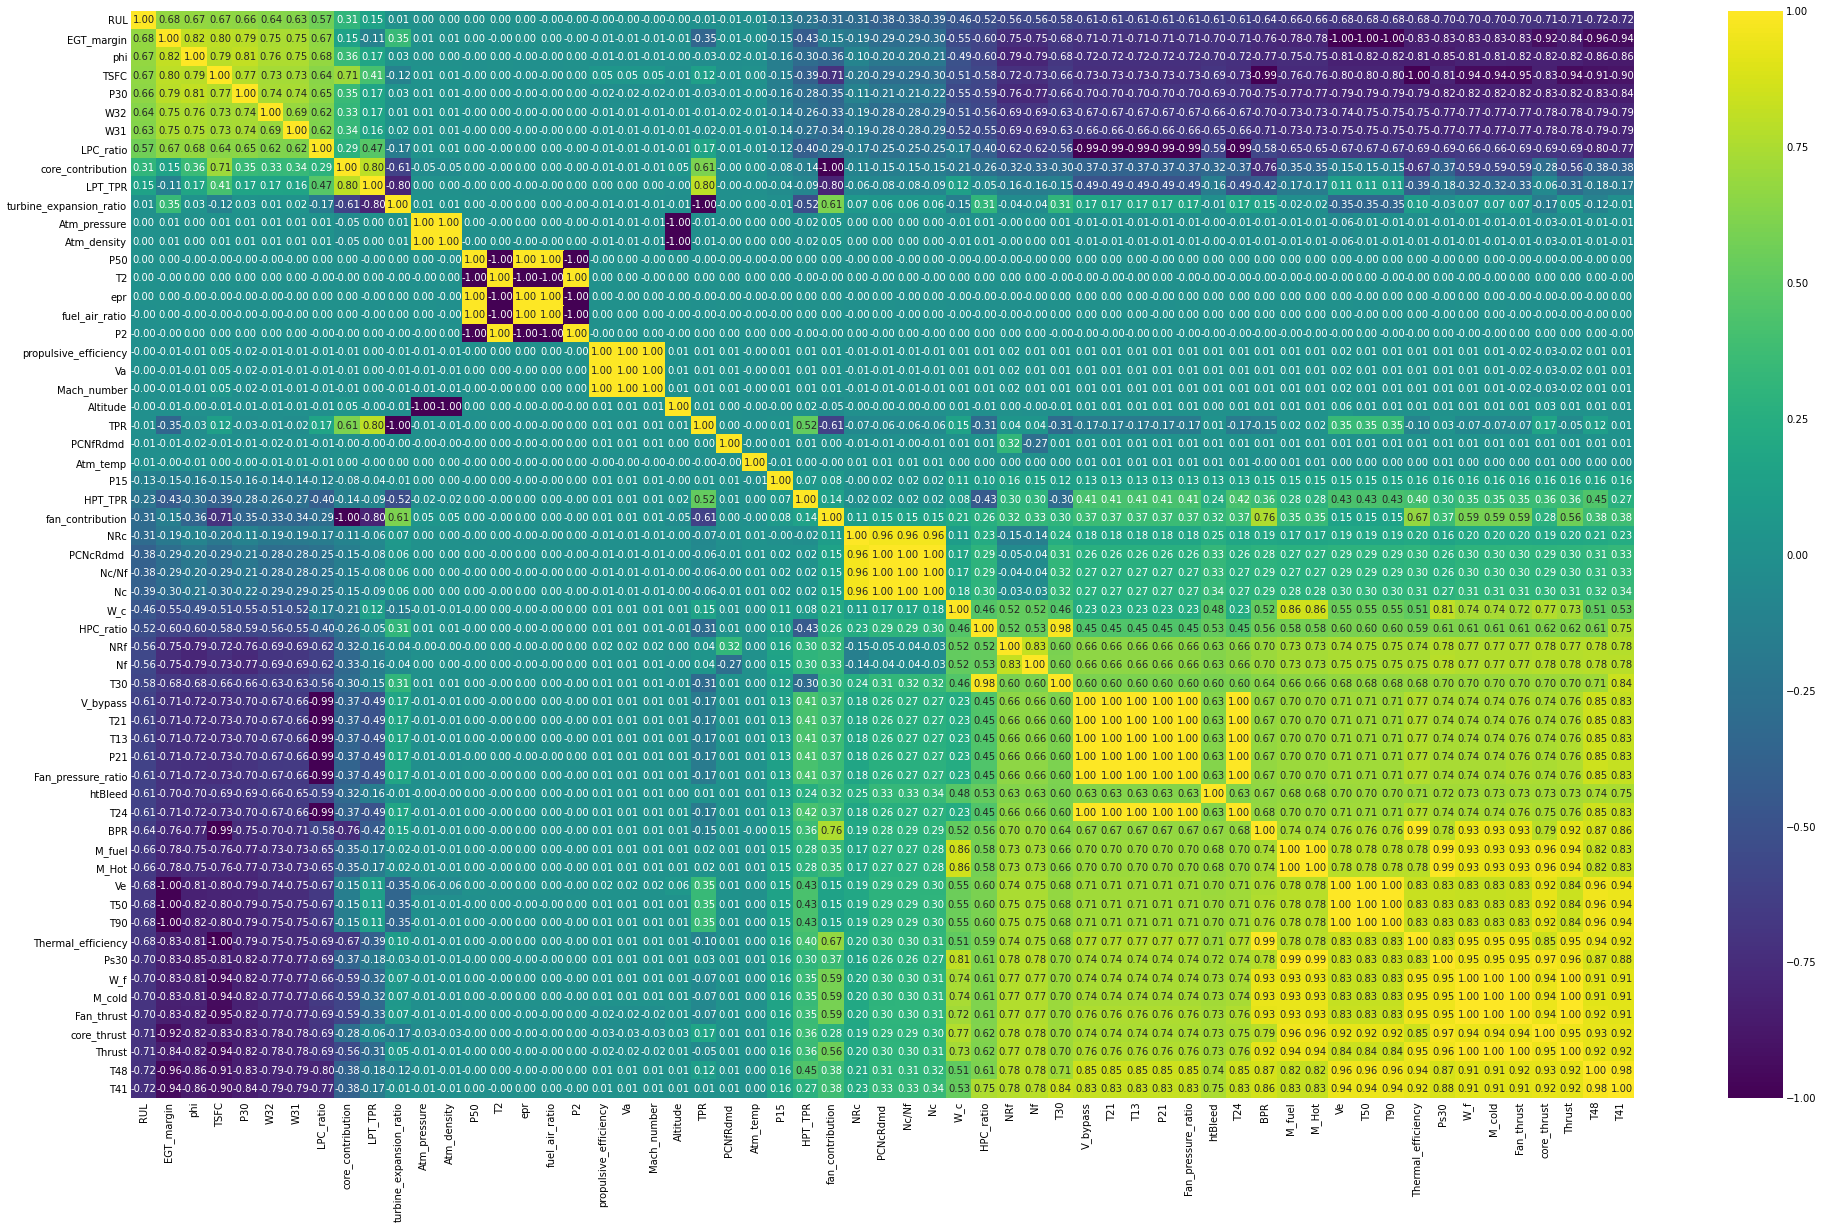

In [ ]:
target = 'RUL'
k = 61 #number of variables for heatmap 
cols = Train[Train.columns[2:]].corr().nlargest(k, target)[target].index
cm = Train[cols].corr()
plt.figure(figsize=(30,20))
sns.heatmap(cm, vmax=1.0, annot=True, fmt='.2f', cmap = 'viridis')

# Feature selection

In [ ]:
y_train =  Train['RUL'] 
x_train =  Train.drop(['RUL','Engine_No','Time_in_cycles'],axis = 1) 

y_val =  Test['RUL'] 
x_val =  Test.drop(['RUL','Engine_No','Time_in_cycles'],axis = 1) 

## Clipped RUL 
y_train_clipped = y_train.clip(upper=125) 
y_val_clipped = y_val.clip(upper=125) 

In [ ]:
# Run model with best hyper paramaters 
regr = RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5, n_estimators =30, random_state=42) 
regr.fit(x_train, y_train_clipped)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# performance matrix
def evaluate(y_true, y_hat, label='test'):
  mse = mean_squared_error(y_true, y_hat)
  rmse = np.sqrt(mse)
  variance = r2_score(y_true, y_hat)  
  print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance)) 

In [ ]:
# predict and evaluate
y_hat_train = regr.predict(x_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_val = regr.predict(x_val)
evaluate(y_val_clipped, y_hat_val) 

train set RMSE:11.586425671516212, R2:0.9226970775541493
test set RMSE:17.4631646986212, R2:0.5990571998816054


In [ ]:
# Feature selection 
select_features = SelectFromModel(regr, threshold='mean', prefit=True)
select_features.get_support() 
print('Original features:\n', x_train.columns)
print('Best features:\n', np.array(x_train.columns)[select_features.get_support()])
np.array(x_train.columns)[select_features.get_support()].shape 

Original features:
 Index(['Altitude', 'Mach_number', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2',
       'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
       'fuel_air_ratio', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32',
       'Atm_pressure', 'Atm_temp', 'Atm_density', 'Va', 'T48', 'T41',
       'turbine_expansion_ratio', 'HPC_ratio', 'T21', 'Fan_pressure_ratio',
       'P21', 'T13', 'V_bypass', 'LPC_ratio', 'P50', 'T90', 'Ve', 'EGT_margin',
       'Nc/Nf', 'PCNfRdmd ', 'PCNcRdmd ', 'HPT_TPR', 'LPT_TPR', 'TPR',
       'M_fuel', 'M_Hot', 'M_cold', 'W_f', 'W_c', 'Thrust', 'Fan_thrust',
       'core_thrust', 'fan_contribution', 'core_contribution', 'TSFC',
       'Thermal_efficiency', 'propulsive_efficiency'],
      dtype='object')
Best features:
 ['T50' 'P30' 'Nc' 'Ps30' 'phi' 'NRc' 'W31' 'T48' 'T41' 'T90' 'Ve'
 'EGT_margin' 'Nc/Nf' 'PCNcRdmd ' 'W_f' 'Thrust' 'Fan_thrust'
 'core_thrust' 'TSFC' 'Thermal_efficiency']


(20,)

In [ ]:
x_train = x_train[np.array(x_train.columns)[select_features.get_support()]] 
x_val =   x_val[np.array(x_val.columns)[select_features.get_support()]]

In [ ]:
df_train = Train[['RUL','Engine_No']] 
df_test =  Test[['RUL','Engine_No']] 

In [ ]:
x_train = pd.concat([x_train, df_train],axis=1)
x_val =   pd.concat([x_val, df_test], axis=1)

In [ ]:
x_train.to_csv('Feature_sele_Train_F0001.csv', encoding='utf-8',index = None)  
x_val.to_csv('Feature_sele_Test_F0001.csv', encoding='utf-8',index = None) 

In [ ]:
imp_col = ['T50','Nf','Ps30','phi','NRf','NRc','BPR','W31','W32','T48','T41','T90','Ve','EGT_margin','Nc/Nf','PCNcRdmd ','M_cold','W_f','Thrust','Fan_thrust','core_thrust','TSFC','Thermal_efficiency']